This code prepares the Nikkei 225 stock index data for training an LSTM model to forecast future stock prices. It includes essential steps for preprocessing, differencing, scaling, and data transformation.

📌 **Detailed Breakdown**
1. **Imports and Random Seed Setup**
Imports necessary libraries for data handling (pandas, numpy), plotting (matplotlib), scaling, evaluation, and deep learning (TensorFlow).
Sets random seeds for reproducibility of results.

2. **Data Loading**
Loads a CSV file Nikkei_225.csv with stock data.
Uses the Close column as the target time series.
raw_series: reshaped to column vector for processing.
raw_values: flattened for later use in inverse operations.

3. **Differencing**
difference(): Converts the time series to a stationary form by subtracting each value from its previous value (lag-1 differencing).
inverse_difference(): Reconstructs the original scale from the differenced prediction.

4. **Supervised Learning Transformation**
series_to_supervised(): Converts the time series into a supervised learning format (lagged input → output), which is necessary for LSTM training.

5. **Scaling**
scale(): Applies MinMaxScaler (range -1 to 1) to normalize the training and testing data.
Ensures LSTM input is within a consistent scale range to help learning.

6.**Inverse Scaling**
invert_scale(): Converts predictions back to the original scale using the fitted scaler, allowing meaningful comparison with real stock prices.

**✅ Purpose**
This is a full preprocessing pipeline for LSTM models applied to time series forecasting. It transforms raw stock data into a clean, normalized, supervised format with differencing and scaling, ready for model training and prediction.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras import optimizers
from math import sqrt
import random
import numpy as np
import tensorflow as tf

random.seed(7)
np.random.seed(7)
tf.random.set_seed(7)

# --- Load dataset ---
df = pd.read_csv('Nikkei_225.csv', index_col='Date', parse_dates=True)
raw_series = df['Close'].values.reshape(-1, 1)
raw_values = raw_series.flatten()  # used for inverse differencing later

# --- Differencing ---
def difference(dataset, interval=1):
    return np.array([dataset[i] - dataset[i - interval] for i in range(interval, len(dataset))])

def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# --- Transform to supervised with 1 lag ---
def series_to_supervised(data, n_lags=1):
    df = pd.DataFrame(data)
    cols = [df.shift(i) for i in range(n_lags, 0, -1)]
    cols.append(df)
    df_supervised = pd.concat(cols, axis=1)
    df_supervised.dropna(inplace=True)
    return df_supervised.values

# --- Scaling ---
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# --- Invert scaling ---
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row).reshape(1, len(new_row))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


This section prepares time series data for training an LSTM model by applying a series of preprocessing steps:

**Lag Configuration:** It sets the number of past observations (lags) used to predict the next value — in this case, just one lag.

**Stationarity Transformation:** The data is differenced to remove trends and make the time series stationary, which helps the model learn better.

**Supervised Format Conversion:** The differenced series is then transformed into a supervised learning format, where each input corresponds to its previous value(s).

**Train-Test Splitting:** The dataset is split into a 70% training set and a 30% testing set to evaluate model performance later.

**Scaling:** Both the training and testing sets are normalized to a range of [-1, 1] using Min-Max scaling, which stabilizes LSTM training.

**Reshaping for LSTM:** Finally, the training inputs are reshaped into a 3D structure (samples, time steps, features), which is the required input format for LSTM models.



In [10]:
# --- Config ---
n_lags = 1
diff_series = difference(raw_series, interval=1)
supervised = series_to_supervised(diff_series, n_lags)
train_size = int(len(supervised) * 0.7)
train, test = supervised[:train_size], supervised[train_size:]
scaler, train_scaled, test_scaled = scale(train, test)

# --- LSTM input format ---
X_train, y_train = train_scaled[:, :-1], train_scaled[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

This part of the code defines, trains, and prepares an LSTM (Long Short-Term Memory) model for time series forecasting. It also includes a function to make single-step predictions.

**📌 Key Components Explained**
1. **Model Definition and Training (fit_lstm):**
A stateful LSTM model is built using Keras.
Stateful means the hidden state is preserved across batches during training, which helps the model capture longer-term dependencies in time series data.
The model takes in sequences with a fixed batch size and time step (1 in this case).
It has:
An LSTM layer with 20 neurons to learn temporal patterns.
A Dense output layer to produce one forecast value.
The Adam optimizer is used with gradient clipping (clipvalue=1e-4) to stabilize training and prevent exploding gradients.
The model is trained one epoch at a time using a for-loop, and the LSTM states are reset at the end of each epoch.
2. **Forecast Function (forecast_lstm):**
This function reshapes the input and feeds it to the trained LSTM model to get a one-step ahead forecast.
It's designed for rolling prediction, i.e., predicting one value at a time in a loop.
3. **Model Training:**
The LSTM model is trained on the prepared training dataset.
After training, it runs a dummy prediction over the training data to build the LSTM’s internal state, preparing it for more accurate forecasts.
**✅ Purpose:**
This section establishes a robust training and prediction framework using a stateful LSTM. It's especially suited for small datasets and sequential prediction tasks, like stock market forecasting, where memory of past values is critical.



In [11]:

# --- LSTM model ---
def fit_lstm(train_X, train_y, batch_size=1, nb_epoch=1, neurons=20):
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, train_X.shape[1], train_X.shape[2])))
    model.add(LSTM(neurons, stateful=True))
    model.add(Dense(1))
    optimizer = optimizers.Adam(clipvalue=1e-4)
    model.compile(loss='mean_squared_error', optimizer="adam")

    for i in range(nb_epoch):
        print(f"Epoch #{i+1}")
        model.fit(train_X, train_y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.layers[0].reset_states()

    return model

# --- Forecast function ---
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size, verbose=0)
    return yhat[0, 0]

# --- Train model ---
lstm_model = fit_lstm(X_train, y_train, batch_size=1, nb_epoch=1, neurons=20)

# --- Build state by predicting training set ---
train_reshaped = X_train
_ = lstm_model.predict(train_reshaped, batch_size=1)



Epoch #1
281/281 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0826
281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


**Summary: Rolling Forecasting with a Primed LSTM Model**

This section performs rolling one-step-ahead forecasting on the test dataset using the trained and stateful LSTM model. It simulates real-world forecasting where only past data is known at each prediction step.

**📌 Step-by-Step Breakdown**
1. **Iterative Prediction:**
The model iterates through the test data, one time step at a time.
For each time step:
The model uses current input features (X) to predict the next value (yhat).
The ground truth (expected) for evaluation is taken from the original raw series.
2. **Postprocessing
Each prediction undergoes two essential reversals to bring it back to its original scale:**
Inverse Scaling: Undoes the MinMax scaling to retrieve the forecast in the original numeric scale.
Inverse Differencing: Restores the trend that was removed during preprocessing, allowing meaningful comparison to actual prices.
3. **Evaluation:**
The Root Mean Squared Error (RMSE) is calculated between the actual values and model forecasts.
RMSE gives a quantitative sense of prediction error in the same units as the target variable (stock price).
4. **Visualization:**
A plot is generated to visually compare the actual stock prices with the predicted prices.
This helps assess how well the model captures the trends and fluctuations of the test period.
**✅ Purpose**
This final stage mimics a real-time forecasting environment, showing how the model would behave in practice — making one prediction at a time as new data arrives, while maintaining state between predictions for improved accuracy.



✅ Rolling LSTM Forecast RMSE: 75.51


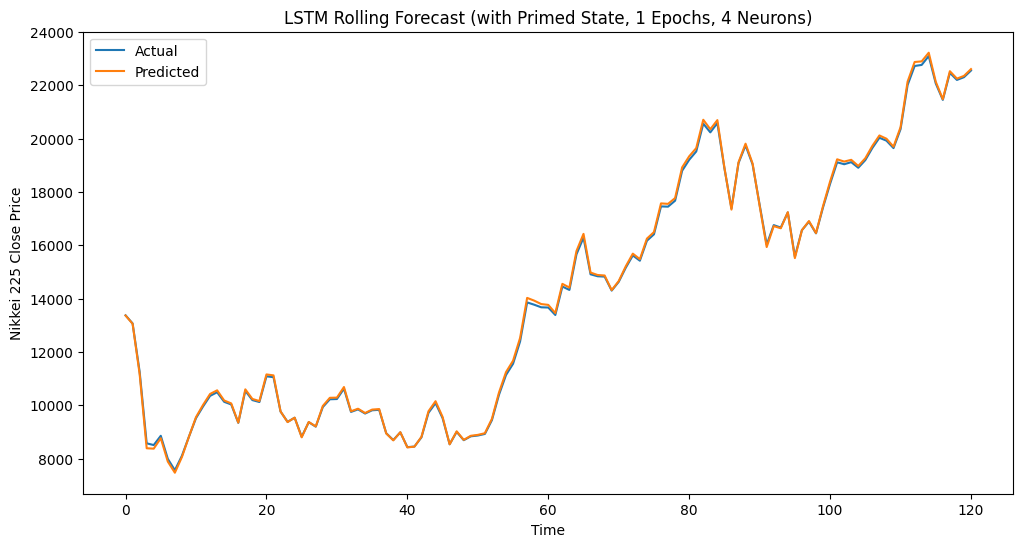

In [12]:
# --- Rolling Forecast on Test Set ---
predictions = []
actuals = []

for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]

    # Forecast
    yhat = forecast_lstm(lstm_model, 1, X)

    # Invert scale
    yhat = invert_scale(scaler, X, yhat)

    # Invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)

    # Store
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    actuals.append(expected)

# --- Evaluate ---
rmse = sqrt(mean_squared_error(actuals, predictions))
print(f"✅ Rolling LSTM Forecast RMSE: {rmse:.2f}")

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('LSTM Rolling Forecast (with Primed State, 1 Epochs, 4 Neurons)')
plt.xlabel('Time')
plt.ylabel('Nikkei 225 Close Price')
plt.legend()
plt.show()
